# ResNet

In [1]:
import chainer
import pickle
import numpy as np

## 訓練データ

cifar10から作成したサイズの小さいデータセット  
・飛行機、自動車、鳥の3クラス  
・各100枚の画像とラベル

In [2]:
with open('data/classification_data.pkl', 'rb') as f:
    dic = pickle.load(f)

data = dic['data']
labels = dic['labels']
label_names = dic['label_names']
print(data.shape, labels.shape, label_names)

(300, 3072) (300,) [b'airplane', b'automobile', b'bird']


In [3]:
# データchainerに適する形に変換（型はfloat32 or int32、画像は(batch_size, channel, width, height)）
# 画像は255で割って0~1に変換
data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
labels = np.array(labels, dtype=np.int32)

In [4]:
# イテレーターを作成
train = chainer.datasets.TupleDataset(data, labels)
train_iter = chainer.iterators.SerialIterator(train, batch_size=64)

## モデル

サイズの小さいResNet

In [5]:
from chainer import functions as F
from chainer import initializers
from chainer import links as L

class BasicA(chainer.Chain):
    # (特徴マップの)sizeが変わるときの残差ブロック
    def __init__(self, in_size, ch, stride):
        super(BasicA, self).__init__()
        # 重みの初期値
        w = initializers.HeNormal()

        with self.init_scope():
            # sizeが半分に
            self.conv1 = L.Convolution2D(in_size, ch, ksize=3, 
                                         stride=stride, pad=1, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(ch)      
            self.conv2 = L.Convolution2D(ch, ch, ksize=3, 
                                         stride=1, pad=1, initialW=w, nobias=True)
            self.bn2 = L.BatchNormalization(ch)
            # sizeが半分に
            self.conv3 = L.Convolution2D(in_size, ch, ksize=3, 
                                         stride=stride, pad=1, initialW=w, nobias=True)
            self.bn3 = L.BatchNormalization(ch)

    def __call__(self, x):
        h1 = F.relu(self.bn1(self.conv1(x)))
        h1 = self.bn2(self.conv2(h1))
        
        h2 = self.bn3(self.conv3(x))

        return F.relu(h1 + h2)


class BasicB(chainer.Chain):
    # 普通の残差ブロック
    def __init__(self, in_size, ch):
        super(BasicB, self).__init__()
        # 重みの初期値
        w = initializers.HeNormal()

        with self.init_scope():
            self.conv1 = L.Convolution2D(in_size, ch, ksize=3, 
                                         stride=1, pad=1, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(ch)
            self.conv2 = L.Convolution2D(ch, ch, ksize=3, 
                                         stride=1, pad=1, initialW=w, nobias=True)
            self.bn2 = L.BatchNormalization(ch)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))

        return F.relu(h + x)


class BasicBlock(chainer.ChainList):
    """
    残差ブロックを並べたもの。
    残差ブロックA１個と残差ブロックB複数個
    """
    def __init__(self, layer, in_size, ch, stride=2):
        super(BasicBlock, self).__init__()
        with self.init_scope():
            self.add_link(BasicA(in_size, ch, stride))
            for i in range(1, layer):
                self.add_link(BasicB(ch, ch))

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x


class ResNet(chainer.Chain):
    def  __init__(self, n_classes=3):
        super(ResNet, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 64, ksize=3, stride=1, pad=1,
                                         initialW=initializers.HeNormal(), nobias=True)
            self.bn1 = L.BatchNormalization(64)           
            self.res2 = BasicBlock(2, 64, 64, stride=1)            
            self.res3 = BasicBlock(2, 64, 128) 
            self.res4 = BasicBlock(2, 128, 256)
            self.fc = L.Linear(256, n_classes)
             
    def __call__(self, x):                # size: 32
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), ksize=2, stride=2)     # size: 16
        h = self.res2(h)                   # size: 16
        h = self.res3(h)                   # size: 8
        h = self.res4(h)                   # size: 4
        h = F.average_pooling_2d(h, 4, stride=1)      # size: 1
        h = self.fc(h)

        return h

## 学習

In [6]:
model = L.Classifier(ResNet())
# 最適化手法はモメンタムSGD
optimizer = chainer.optimizers.MomentumSGD(lr=0.05)
optimizer.setup(model)

In [7]:
from chainer import training
from chainer.training import extensions

# trainer設定
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, stop_trigger=(20, 'epoch'), out='result')
# 出力設定
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']))

In [8]:
# 実行
trainer.run()

epoch       iteration   main/loss 
1           5           1.14314     
2           10          0.78476     
3           15          0.62394     
4           19          0.385489    
5           24          0.286218    
6           29          0.433206    
7           33          0.424519    
8           38          0.190338    
9           43          0.0981595   
10          47          0.168876    
11          52          0.115696    
12          57          0.271729    
13          61          0.204037    
14          66          0.189054    
15          71          0.131351    
16          75          0.0471388   
17          80          0.0495198   
18          85          0.00658235  
19          90          0.0108717   
20          94          0.0121343   


In [9]:
# trainer使わないversion

# n_epoch = 20
# while train_iter.epoch < n_epoch:
#     train_batch = train_iter.next()
#     x, t = chainer.dataset.concat_examples(train_batch)
#     loss = model(x, t)
#     model.cleargrads()
#     loss.backward()
#     optimizer.update()
#     if train_iter.is_new_epoch:
#         print('epoch:{:02d} loss:{:.04f} '.format(train_iter.epoch, np.float(loss.data)))

## 結果

簡単のため訓練データに対して実際に学習できているか確認する。
（精度の検証などをするときは検証データやテストデータを別途用意して検証する）

output probabilities : [[  2.28391091e-05   6.78140452e-07   9.99976516e-01]]
prediction : b'bird'
true          : b'bird'


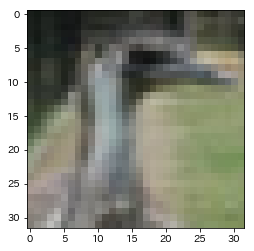

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

test_batch = train_iter.next()
x, t = test_batch[0]
chainer.config.train=False
prob = F.softmax(model.predictor(x[None]))
print('output probabilities : {}'.format(prob.data))  # [b'airplane', b'automobile', b'bird']
print('prediction : {}'.format(label_names[prob.data.argmax()]))
print('true          : {}'.format(label_names[t]))

img = x.reshape(3, 32, 32).transpose((1, 2, 0))
plt.figure()
plt.imshow(img)